In [ ]:
# This notebook explores 2016 fire prediction model performance by state
# The notebook helps to show the makeup of the national model and whether NY skews its performance

In [121]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from matplotlib.lines import Line2D
from shapely.geometry import Point
import plotly.express as px
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
import geopandas
import seaborn as sns
from scipy import stats
from imblearn import under_sampling, over_sampling 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import pairwise
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


%matplotlib inline
plt.style.use('dark_background')
pd.set_option('display.max_columns',500)
sns.set()

import random

SEED = 100
random.seed(SEED)
np.random.seed(SEED)


In [122]:
p = Path.cwd()
data_path = p.parent.parent / 'data' / 'Master Project Data' 
nfirs_path =  data_path / 'NFIRS Fire Incident Data.csv'

# List the columns you want to download from the NFIRS csv
cols_to_use = ['state','fdid','inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','geoid', 'longitude', 'Latitude']

# Specify particular data type for geoid column
col_dtypes = {'geoid':str}

# Read in NFIRS dataframe
nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

# Convert inc_date column values to python datetime type
nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)
#nfirs=nfirs[nfirs.state.isin(['CA', 'MN', 'TN'])]

#Read in ACS dataframe
ACS_path = data_path  / 'ACS 5YR Block Group Data.csv'
ACS = pd.read_csv(ACS_path,
                  dtype = {'GEOID':'object'},
                index_col = 1)

     

/opt/anaconda3/envs/RCP2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



In [123]:
#NFIRS Munging

# Ensure correct calculation of tot_loss column 
nfirs['tot_loss'] = nfirs['prop_loss'] + nfirs['cont_loss']

# Create mask for new severe fire variable
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)

# By default assigns values of severe fire column as not severe
nfirs['severe_fire'] = 'not_sev_fire'

# Applies filter to severe fire column to label the severe fire instances correctly
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'

# Create new NFIRS variables based on specified thresholds of existing variables in dataframe
nfirs['had_inj'] = np.where(nfirs['oth_inj']>0,'had_inj','no_inj')
nfirs['had_death'] = np.where(nfirs['oth_death']>0,'had_death','no_death')
nfirs['10k_loss'] = np.where(nfirs['tot_loss']>=10000,'had_10k_loss','no_10k_loss')

# Extract just the numeric portion of the geoid
nfirs['geoid'] =  nfirs['geoid'].str.strip('#_')

# Add a year column to be used to groupby in addition to geoid
nfirs['year'] = nfirs['inc_date'].dt.year.astype('str')
nfirs.set_index('geoid',inplace = True)

# Create nfirs dataframes without NY or nfirs dataframes with only NY to see how baseline model changes
#nfirs = nfirs[nfirs.state != "NY"]
#nfirs= nfirs[nfirs.state == "NY"]

# Create dataframe to track the states associated with nfirs entries in order to break out model performance by state
States=nfirs[['state']]
States.index.rename('GEOID',inplace = True)
  

In [124]:
# Sets up dataframe with total fires for each state, which will be used in our scatter plot later on
fires_by_state=States.groupby('state').apply(lambda grp: (len(grp)))
state_prefix = (fires_by_state.keys().tolist())
state_index = np.arange(len(state_prefix))
total_fires = fires_by_state.values.tolist()
scatter_plot_df=pd.DataFrame(state_prefix, columns=['state'])
scatter_plot_df['total_fires']=total_fires


In [125]:
# ACS Munging

# Ensures GEOID variable is in the correct format and sets it as the dataframe index
ACS['GEOID'] = ACS['GEOID'].str[2:]

# Create ACS dataframes without NY or ACS dataframes with only NY to see how baseline model changes
#ACS = ACS[ACS['GEOID'].str[0:2] != "36"]
#ACS = ACS[ACS['GEOID'].str[0:2] == "36"]

ACS.set_index(['GEOID'],inplace = True)


# Captures name properies of GEOIDs for later use before filtering dataframe to be numeric features only
Names = ACS[['county_name', 'state_name']]

# Removes extraneous features (i.e. non-numeric) in the dataframe
if 'Unnamed: 0' in ACS.columns:
    ACS.drop('Unnamed: 0','columns',inplace= True)

if 'NAME' in ACS.columns:
    ACS.drop('NAME','columns',inplace= True)

if 'inc_pcincome' in ACS.columns:
    ACS.drop('inc_pcincome','columns',inplace= True)

# Creates vector of total populations for each census block to be used to normalize total fires per year variable
tot_pop = ACS[['tot_population']]

# Drop all total count columns in ACS and keeps all percentage columns
cols = ACS.columns.to_list()
for col in cols:
    if  col.find('tot') != -1 : 
        ACS.drop(col,'columns', inplace = True)


# Integer indexing for all rows, but gets rid of county_name, state_name, and in_poverty
ACS = ACS.iloc[:,3:]

# Remove missing values from dataframe
ACS.replace([np.inf, -np.inf], np.nan,inplace = True)
ACS.dropna(inplace = True)


In [126]:
## Adjust total fires per year by the population counts

# Creates dataframe that shows the number of fires in each census block each year
fires =  pd.crosstab(nfirs.index,nfirs['year'])
fires.index.rename('GEOID',inplace = True)

# Grab total population values pulled from ACS dataframe and assign to each census block in NFIRS dataframe
fires = fires.merge(tot_pop, how = 'left', left_index = True, right_index = True)

# Remove resulting NaN/infinity values following merge
fires.replace([np.inf, -np.inf], np.nan,inplace = True)
fires.dropna(inplace = True)

# drop rows with no population count
fires = fires[fires['tot_population'] != 0 ] 

# population adjustment
fires.loc[:,'2009':'2016'] = fires.loc[:,'2009':'2016'].div(fires['tot_population'], axis = 'index') * 1000
fires = fires.loc[:,:'2016']

# view fires by year across geoids; displays additional information regarding # of fires in higher percentile categories
fires.describe(percentiles=[.75, .85, .9 ,.95, .99])

# define variables to indicate census blocks in the top 10% percent of fire risk scores
top10 = fires > fires.quantile(.9)


In [127]:
# Find correlated features in ACS dataset and identify the highly correlated relationships

# Create ACS correlation matrix
corr = ACS.corr()
 
# Filtering out lower/upper triangular duplicates 
corr_high = corr[abs(corr) > 0.7].stack().reset_index()
corr_high = corr_high[corr_high['level_0'].astype(str)!=corr_high['level_1'].astype(str)]
corr_high['ordered-cols'] = corr_high.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
corr_high = corr_high.drop_duplicates(['ordered-cols'])
corr_high.drop(['ordered-cols'], axis=1, inplace=True)
corr_high.columns = ['Pair Var 1', 'Pair Var 2', 'Corr Value']

# Display highly correlated pairs
corr_high.sort_values(by=['Corr Value'], ascending=False)

# From highly correlated pairs, remove one of the Pair Vars from the ACS dataset except for the 'mort' variables
ACS = ACS.drop(['house_pct_vacant', 'did_not_work_past_12_mo', 'house_pct_non_family', 'house_pct_rent_occupied',
                           'race_pct_nonwhite', 'race_pct_nonwhitenh', 'house_pct_incomplete_plumb',
                           'house_pct_incomplete_kitchen', 'race_pct_whitenh'], axis=1) 

# Based on feature importance experiments, select features with consistence importance across annual predictions
ACS = ACS[['house_yr_pct_earlier_1939', 'house_pct_occupied', 'house_pct_family_married', 'race_pct_black',
          'worked_past_12_mo', 'heat_pct_fueloil_kerosene', 'educ_bachelors', 'house_pct_live_alone', 
          'educ_some_col_no_grad', 'house_pct_ownd_occupied', 'house_w_home_equity_loan', 'house_val_175K_200K',
           'house_val_200K_250K']]



                     Pair Var 1                    Pair Var 2  Corr Value
59         house_pct_non_family          house_pct_live_alone    0.907753
25               race_pct_white              race_pct_whitenh    0.851387
36            race_pct_nonwhite           race_pct_nonwhitenh    0.851387
37            race_pct_nonwhite                race_pct_black    0.802072
48             house_pct_family      house_pct_family_married    0.757961
104    house_pct_complete_plumb    house_pct_complete_kitchen    0.752488
109  house_pct_incomplete_plumb  house_pct_incomplete_kitchen    0.752488
92         heat_pct_utility_gas          heat_pct_electricity   -0.732439
105    house_pct_complete_plumb  house_pct_incomplete_kitchen   -0.752488
108  house_pct_incomplete_plumb    house_pct_complete_kitchen   -0.752488
53     house_pct_family_married          house_pct_non_family   -0.757961
28               race_pct_white                race_pct_black   -0.802072
31             race_pct_whitenh       

In [128]:
# Function to upsample or downsample our dataframe features if we have unbalanced classes

def resample_df(X,y,upsample=True,seed = SEED):
    from sklearn.utils import resample
    # check which of our two classes is overly represented 
    if np.mean(y) > .5:
        major,minor = 1,0
    else:
        major,minor = 0, 1
    
    # Add Class feature to dataframe equal to our existing dependent variable
    X['Class'] = y
    
    df_major = X[X.Class == major ]
    df_minor = X[X.Class == minor ]
    

    if upsample:      
    
        df_minor_resampled = resample(df_minor,
                                     replace = True,
                                     n_samples = df_major.shape[0], 
                                     random_state = seed)
    
    
   
        combined = pd.concat([df_major,df_minor_resampled])
        
        # Debug
        #print('minor class {}, major class {}'.format(df_minor_resampled.shape[0],
                                                       #df_major.shape[0]))
    
        
    else: # downsample
         
        df_major_resampled = resample(df_major,
                                     replace = False,
                                     n_samples = df_minor.shape[0],
                                     random_state = seed)
        
        
        combined = pd.concat([df_major_resampled,df_minor])
        
        #print('minor class {}, major class {}'.format(df_minor.shape[0],
                                                      #df_major_resampled.shape[0]))


    
    
    y_out = combined['Class']
    X_out = combined.drop('Class', axis =1)
    return X_out , y_out

In [129]:
# Function to train model that predicts whether each census block is in the top 10% percent of fire risk scores
def train_model(top10,fires, States, ACS = pd.DataFrame(), nyears = 7, modeltype='BalRF', seed = SEED):
    from scipy.stats import zscore
    
    
    # Define model types & parameters 
    
    if modeltype =='LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(warm_start=True,
                                   class_weight = 'balanced',
                                   max_iter = 1000)

        
    elif modeltype =='BalBagged':
        from imblearn.ensemble import BalancedBaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                          n_estimators=80, sampling_strategy='auto',
                                          random_state=0)
        
    elif modeltype =='BalRF':
        from imblearn.ensemble import BalancedRandomForestClassifier
        model = BalancedRandomForestClassifier(n_estimators=80, sampling_strategy='auto',
                                               max_depth=10, random_state=0,
                                              max_features=None, min_samples_leaf=40)

    elif modeltype =='Bagged':
        from sklearn.ensemble import BaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    n_estimators=40,
                                    random_state=0)
    
    elif modeltype =='RF':
        from imblearn.ensemble import BalancedRandomForestClassifier
        model = BalancedRandomForestClassifier(n_estimators=60,
                                          warm_start = False,
                                          max_depth = 10,
                                            random_state = 0)
    
    
    # Create framework to predict whether a given census block has a fire risk score in the 90th percentile 
            # based on the specific number of previous years' data
        
    years = top10.columns
    
    
    start_pointer = 0
    end_pointer = nyears-1
    y_pointer = nyears
    while y_pointer < len(years):
        X_start, X_end = start_pointer, end_pointer
       
        X = fires.iloc[:,X_start:X_end].copy()
            
        L = X.shape[1] 
        X.columns = ['year-{}'.format(L - year) for year in range(L)]
        
        sm = np.sum(X, axis = 1 )
        mu = np.mean(X, axis = 1)
        mx = np.max(X, axis =1)
        X['Sum']  = sm
        X['Mean'] = mu
        X['Max']  = mx
        y = top10.iloc[:,y_pointer]
    
        # merge in ACS Data into X unless NFIRS-Only model
        if not ACS.empty:
            X=X[['Sum','Mean','Max']] # drop all other NFIRS columns that have low feature importance scores
            X = X.merge(ACS, how ='left',left_index = True, right_index = True)
            X = X.dropna()
            y = y.filter(X.index)
        
        
        
        # Create 80/20 training/testing set split
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .3 )
        
        # Perform resampling if data classes are unbalanced
        X_train, y_train = resample_df(X_train,y_train)
        
        
        # Standardize features by removing the mean and scaling to unit variance
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        scaler.transform(X_train)
        scaler.transform(X_test)
        
        
        # Fit model to training set
        
        print('Predicting {}:'.format(years[y_pointer]) )
        model = model.fit(X_train,y_train)

        
        # Calculate training set performance
        
        train_prediction_probs = model.predict_proba(X_train)
        train_predictions = model.predict(X_train)
        
        
        # Calculate test set performance
        
        test_prediction_probs = model.predict_proba(X_test)
        test_predictions = model.predict(X_test)
        
        # Calculate true recall for each entry in the test set
        results=y_test.to_frame()
        results['test_predictions']=test_predictions
        results['score_value'] = results.apply(lambda x: "TP" if (x['2016']==True and x['2016']==x['test_predictions']) 
                                               else ("FN" if (x['2016']==True and 
                                                x['test_predictions']==False) else "NO"),
                                                axis=1)
        results=results.rename(columns={"2016": "Labels"})
        
        # Assign states to GEOIDs in the test set
        new_states = States[States.index.isin(results.index.tolist())]
        new_states = new_states.loc[~new_states.index.duplicated(keep='first')]
        
        # Output true recall performance by state
        results = results.merge(new_states, how = 'left', left_index = True, right_index = True)
        results_true_recall=results.groupby('state').apply(lambda grp: ((sum(grp['score_value']=="TP"))
                                                           /(sum(grp['score_value']=="TP") +
                                                             sum(grp['score_value']=="FN")))*100)
        
        # Create bar chart showing true recall for each state
        objects = (results_true_recall.keys().tolist())
        y_pos = np.arange(len(objects))
        performance = results_true_recall.values.tolist()
        plt.figure(figsize=(20,10))
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        
        # Plot horizontal line on bar chart indicating true recall for national model
        plt.hlines(y = 68, xmin = -0.5, xmax = 50.5, color ='r') 
        plt.text(50.5, 68, ' Nat\'l: 68', ha='left', va='center')
        plt.xticks(y_pos, objects)
        plt.ylabel('True Recall %')
        plt.title('True Recall Performance by State')
        plt.show()
        
        # Creates heatmap of united states with color scale indicating the model's performance by state
        #fig = px.choropleth(locations=objects, locationmode="USA-states", color=performance,
                            #range_color=(0,100), color_continuous_scale='solar',
                            #labels={'color':'true_recall', 'locations':'state'},
                            #scope="usa")
        #fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, title_text = 'True Recall % by State')
        #fig.show()
        
        
        print (confusion_matrix(y_test, test_predictions))
        print (classification_report(y_test,test_predictions))
        
        
        #Calculate feature importance for each model
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        print("Feature ranking:")
        for f in range(len(X_test.columns)):
            print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]]))
        
        # Increment sliding prediction window
        start_pointer += 1
        end_pointer += 1
        y_pointer += 1
    
    
            
    return model,X_test,y_test,performance 
        


<ipython-input-128-43754c6ac020>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Predicting 2016:


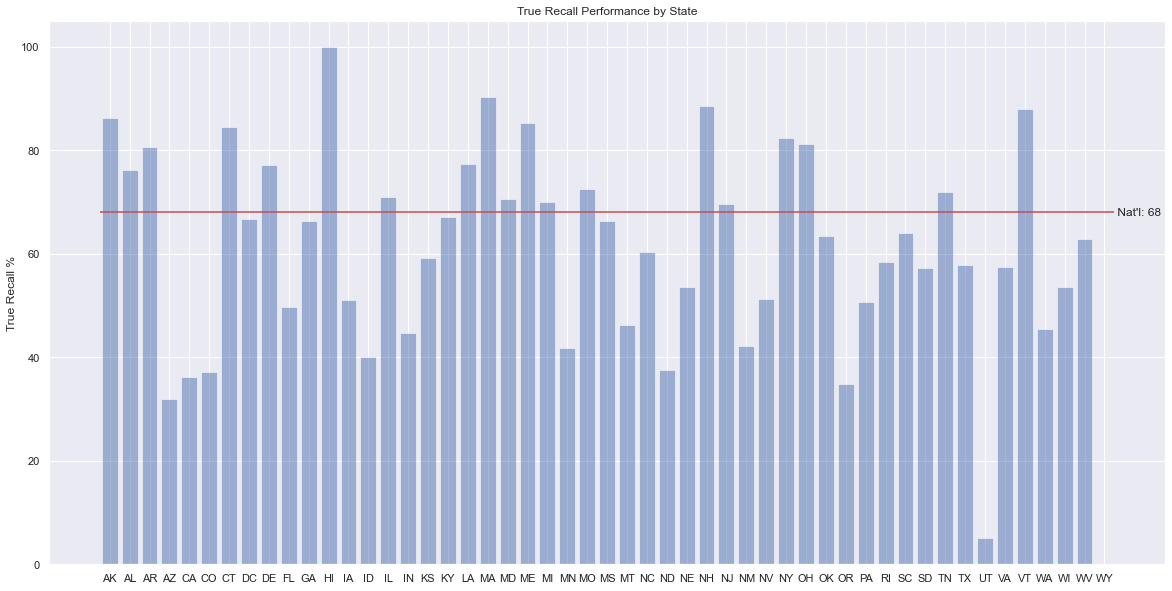

[[41452 11711]
 [ 1829  3957]]
              precision    recall  f1-score   support

       False       0.96      0.78      0.86     53163
        True       0.25      0.68      0.37      5786

    accuracy                           0.77     58949
   macro avg       0.61      0.73      0.61     58949
weighted avg       0.89      0.77      0.81     58949



In [130]:
# Train NFIRS + ACS Model and output prediction performance metrics for each year (nyears=7 to predict 2016 performance)
mdl,X_test,y_test,performance=train_model(top10.loc[:,'2009':'2016'],fires, States,ACS = ACS,nyears=7, modeltype='BalRF')

[85.71428571428571, 78.64077669902912, 79.3103448275862, 33.33333333333333, 40.74074074074074, 38.775510204081634, 82.6530612244898, 80.0, 75.67567567567568, 60.35502958579882, 72.05882352941177, 100.0, 58.06451612903226, 58.333333333333336, 72.37237237237237, 40.57971014492754, 60.526315789473685, 72.72727272727273, 78.76106194690266, 88.5286783042394, 62.62626262626263, 72.72727272727273, 73.1638418079096, 50.33557046979866, 77.6595744680851, 79.66101694915254, 30.0, 61.440677966101696, 22.22222222222222, 60.60606060606061, 74.19354838709677, 73.91304347826086, 40.0, 52.63157894736842, 77.91798107255521, 67.16417910447761, 37.93103448275862, 57.03703703703704, 66.66666666666666, 72.41379310344827, 50.0, 79.3103448275862, 65.65656565656566, 13.636363636363635, 57.23684210526315, 85.0, 36.0, 57.95454545454546, 62.19512195121951, 100.0]


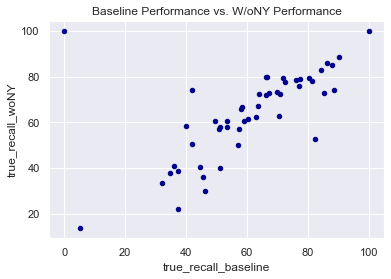

In [146]:
# Scale total fires by state to match scale of true recall percentage
x = np.array(total_fires).reshape(-1,1)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled=x_scaled*100

# Create scatter plot that evaluates whether true recall performance is better for states that have more data
scatter_plot_df['fires_scaled']=x_scaled
scatter_plot_df['true_recall']=performance
ax1 = plot_df.plot.scatter(x='fires_scaled', y='true_recall', c='DarkBlue')

# Plot line with slope=1; in theory states' true recall will higher if the model contains more data for them
# Observing where the points fall along this line will demonstrate the overall trend for our model
x_0 = 0
y_0 = 0
x_1 = 100
y_1 = 100

ax1.plot([x_0, x_1], [y_0, y_1], c='r')    
plt.title('Baseline Performance vs. W/oNY Performance')
plt.show()